# Day11
简单 CNN on CIFAR10 架构搭建与训练（目标准确率 ≥70%）  
`Sequential`, early stopping, `torch.optim.lr_scheduler.StepLR`


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**数据增强**    
常见的数据增强方法及其适用数据类型：   
- 图像数据 (Image Data) 🖼️：
    - 几何变换：
    - 随机翻转 (Random Flip): 
        - 水平翻转 (RandomHorizontalFlip) 或垂直翻转(RandomVerticalFlip)
    - 随机裁剪 (Random Crop): 从图像的随机位置裁剪出固定大小的区域。迫使模型关注图像的不同部分，也模拟了物体可能出现在图片的不同位置
    - (RandomResizedCrop) 结合缩放 
    - 随机旋转 (Random Rotation): 在一定角度范围内随机旋转图像。
    - 随机平移 (Random Translation) / 仿射变换 (Affine Transformation): 随机移动图像内容或应用更复杂的仿射变换（包括缩放、旋转、剪切、平移）。
    - 随机缩放 (Random Zoom): 随机放大或缩小图像。
    - 颜色变换：随机亮度、对比度、饱和度、色调调整 (Color Jitter): 随机改变图像的颜色属性，模拟不同光照条件或相机设置。
    - 随机灰度化 (Random Grayscale): 以一定概率将图像转换为灰度图。
    - 噪声注入：
        - 添加高斯噪声 (Gaussian Noise): 模拟传感器噪声。
        - 椒盐噪声 (Salt-and-Pepper Noise): 模拟图像传输中的干扰。
        - 擦除/遮挡 (Random Erasing / Cutout): 随机擦除图像的矩形区域，迫使模型关注物体的非全部部分，提高对部分遮挡的鲁棒性。
    - 混合图像 (Mixup / Cutmix):
        - Mixup: 将两张图片按比例线性叠加，对应的标签也按比例混合。
        - Cutmix: 将一张图片的裁剪区域“粘贴”到另一张图片的随机位置，标签也按区域比例混合。  

这些方法有助于模型学习更线性的决策边界，提高泛化能力和对抗攻击的鲁棒性。   
自动化数据增强 (AutoAugment / RandAugment): 不手动定义增强策略，而是通过算法（如强化学习或简单的搜索）自动寻找最佳的增强策略组合。   

- 结构化/表格数据 (Tabular Data) 📊：
结构化数据的数据增强相对困难，因为特征之间有复杂的数值或类别关系，随机变换很容易破坏数据的真实分布或引入不合理的样本。
    - 少量噪声注入： 对数值特征添加少量随机噪声。
    - 随机交换特征值： 在同一个特征列中，随机交换不同样本的值（需要非常小心，可能破坏特征间的关系）。
    - 生成合成数据 (Synthetic Data Generation): 使用 GAN, VAE, 或基于树的方法 (如 CTGAN) 生成新的、看起来像真实数据的样本。这是结构化数据增强的一个重要方向，但技术门槛较高。
    - SMOTE (Synthetic Minority Over-sampling Technique): 专门用于处理类别不平衡，通过在少数类样本之间插值生成新的样本。

In [3]:
transform = transforms.Compose([ # 做一些数据增强
    transforms.RandomHorizontalFlip(),      # 随机水平翻转
    transforms.RandomCrop(32, padding=4),   # 随机裁剪
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 使用均值和标准差进行标准化
])

full_train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

因为训练的时候要用到早停，需要验证集，使用三分法。

In [4]:
train_size = int(0.8 * len(full_train_dataset))  # 80% 用于训练
val_size = len(full_train_dataset) - train_size   # 20% 用于验证

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

一个批次的图像形状: torch.Size([128, 3, 32, 32])
一个批次的标签形状: torch.Size([128])


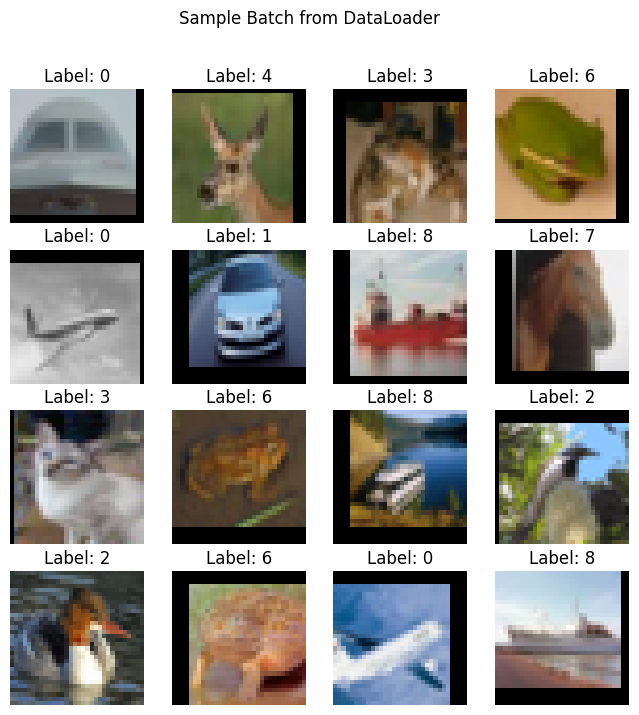

In [6]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"一个批次的图像形状: {images.shape}") # [batch_size, channels, height, width]
print(f"一个批次的标签形状: {labels.shape}") # [batch_size]

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5 # 反归一化
    plt.imshow(img.numpy())
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Sample Batch from DataLoader")
plt.show()

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1_sequence = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2_sequence = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.ffn_sequence = nn.Sequential(
            nn.Linear(32 * 8 * 8, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.BatchNorm1d(10)
        )

    def forward(self, x):
        x = self.conv1_sequence(x)
        x = self.conv2_sequence(x)
        x = x.view(-1, 32 * 8 * 8)
        x = self.ffn_sequence(x)
        return x

In [ ]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=10, gamma=0.5) # 每隔10个epoch将学习率减半

下面的训练结合早停策略   
early stoppint的patience要和StepLR的step_size配合，一般是patience=k*step_size

In [ ]:
epochs = 50
best_val_loss = float('inf')
patience = 10  # 容忍多少个epoch没有提升
trigger_times = 0
print('start traning...') 
for epoch in range(epochs):
    model.train()
    for _, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0  # 有提升，重置计数
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

start traning...
Epoch 1, Val Loss: 1.4016
Epoch 2, Val Loss: 1.2508
Epoch 3, Val Loss: 1.1726
Epoch 4, Val Loss: 1.1241
Epoch 5, Val Loss: 1.0779
Epoch 6, Val Loss: 1.0553
Epoch 7, Val Loss: 1.0115
Epoch 8, Val Loss: 0.9694
Epoch 9, Val Loss: 0.9783
Epoch 10, Val Loss: 0.9447
Epoch 11, Val Loss: 0.9009
Epoch 12, Val Loss: 0.8965
Epoch 13, Val Loss: 0.8979
Epoch 14, Val Loss: 0.8820
Epoch 15, Val Loss: 0.9026
Epoch 16, Val Loss: 0.8675
Epoch 17, Val Loss: 0.8646
Epoch 18, Val Loss: 0.8629
Epoch 19, Val Loss: 0.8695
Epoch 20, Val Loss: 0.8504
Epoch 21, Val Loss: 0.8288
Epoch 22, Val Loss: 0.8204
Epoch 23, Val Loss: 0.8108
Epoch 24, Val Loss: 0.8141
Epoch 25, Val Loss: 0.8123
Epoch 26, Val Loss: 0.8045
Epoch 27, Val Loss: 0.8062
Epoch 28, Val Loss: 0.8001
Epoch 29, Val Loss: 0.8052
Epoch 30, Val Loss: 0.8193
Epoch 31, Val Loss: 0.7876
Epoch 32, Val Loss: 0.7846
Epoch 33, Val Loss: 0.7800
Epoch 34, Val Loss: 0.7753
Epoch 35, Val Loss: 0.7810
Epoch 36, Val Loss: 0.7807
Epoch 37, Val Loss: 

In [12]:
model.eval()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
with torch.no_grad(): 
    correct = 0
    total = 0
    classes_correct = [0] * 10
    classes_total = [0] * 10
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        
        idx, predicted = torch.max(outputs.data, 1) # outputs.data 和 outputs 差不多，但更明确不跟踪梯度

        total += labels.size(0) # 累加样本总数
        correct += (predicted == labels).sum().item() # 累加正确预测的数量
        for i in range(1000):
            label = labels[i]
            classes_correct[label] += (predicted[i] == label).item()
            classes_total[label] += 1
    for i in range(10):
        print(f"类别 {classes[i]} 的准确率: {100 * classes_correct[i] / classes_total[i]:.2f} %")
        
    accuracy = 100 * correct / total
    print(f'测试集上的准确率: {accuracy:.2f} %')
    
print("评估完成！")

类别 plane 的准确率: 78.80 %
类别 car 的准确率: 84.90 %
类别 bird 的准确率: 60.00 %
类别 cat 的准确率: 53.20 %
类别 deer 的准确率: 72.40 %
类别 dog 的准确率: 64.80 %
类别 frog 的准确率: 81.50 %
类别 horse 的准确率: 77.70 %
类别 ship 的准确率: 83.10 %
类别 truck 的准确率: 82.20 %
测试集上的准确率: 73.86 %
评估完成！
